In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, TimeDistributed, Bidirectional, Concatenate, GlobalAveragePooling1D, AdditiveAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer


In [2]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [3]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open('best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## LSTM

In [5]:
tf.random.set_seed(42)

#batch_size = None
#batch_size=64

def model_build(params):
    lstm_units = params['lstm_units']
    dense_2_units = params['dense_2_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    model = Sequential()
    model.add(Input(shape=(20,)))
    # Adding the Embedding layer with pre-trained weights and specifying input_length
    model.add(Embedding(input_dim=embeddings_GloVe.shape[0],
                        output_dim=embeddings_GloVe.shape[1],
                        weights=[embeddings_GloVe],
                        trainable=False))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, # Number of hidden states, number of reccurent units for each vector
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0.2,
        return_sequences=False)))

    model.add(Dense(dense_2_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

num_classes = 1
model = model_build(params)
# Model summary
model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2223500   
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 160)               115840    
 al)                                                             
                                                                 
 dense (Dense)               (None, 92)                14812     
                                                                 
 dropout_1 (Dropout)         (None, 92)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 93        
                                                       

In [6]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Epoch 1/20


282/282 [==============================] - 23s 31ms/step - loss: 0.5958 - accuracy: 0.6820 - val_loss: 0.5503 - val_accuracy: 0.7256
Epoch 2/20
282/282 [==============================] - 7s 25ms/step - loss: 0.5274 - accuracy: 0.7311 - val_loss: 0.5261 - val_accuracy: 0.7474
Epoch 3/20
282/282 [==============================] - 7s 26ms/step - loss: 0.4713 - accuracy: 0.7715 - val_loss: 0.5377 - val_accuracy: 0.7339
Epoch 4/20
282/282 [==============================] - 7s 26ms/step - loss: 0.4036 - accuracy: 0.8137 - val_loss: 0.5511 - val_accuracy: 0.7350
Epoch 5/20
282/282 [==============================] - 7s 26ms/step - loss: 0.3435 - accuracy: 0.8418 - val_loss: 0.5883 - val_accuracy: 0.7474


61/61 [==============================] - 1s 9ms/step - loss: 0.5848 - accuracy: 0.7532
Test Loss: 0.5848084092140198
Test Accuracy: 0.7532400488853455


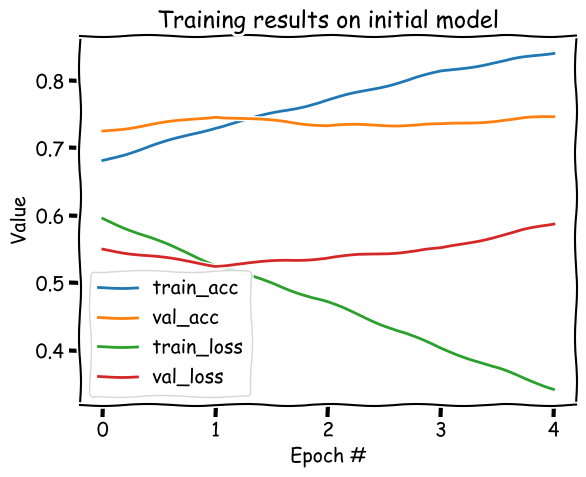

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()